# Selekcja cech i redukcja wymiarowości

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo Seaborn dla wizualizacji.

**Uwaga:** upewnij się, że masz scikit-learn w wersji 1.2 lub nowszej. Dzięki temu będzie można ustawić opcję `transform_output="pandas"`, dzięki której wszystkie transformatory w scikit-learn będą nie tylko przyjmować, ale też zwracać DataFrame, zachowując nazwy zmiennych. Będzie to bardzo przydatne w analizie danych.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza cech

Ponownie wykorzystamy zbiór danych [Ames housing](https://www.openintro.org/book/statdata/?data=ames), w którym zadaniem jest przewidywanie wartości domu na podstawie cech budynku, działki, lokalizacji itp. Ma on duży zbiór wejściowych cech, odpowiadający typowym wartościom ze stron handlujących nieruchomościami, więc odpowiada realnym potrzebom analizy biznesowej.

Interpretowalność jest tutaj kluczowa, bo każdy sprzedający chce zyskać jak najwięcej. Informacja, które cechy nie mają znaczenia dla kupujących, a na które jest zwracana największa uwaga, mogą np. pokierować decyzjami, które części domu wyremontować przed ogłoszeniem sprzedaży. Z kolei cechy o niskiej ważności warto odrzucić nie tylko, aby pomóc modelowi ML, ale też żeby np. nie wspominać o tych elementach w ogłoszeniu, bo i tak mało kogo obchodzą.

Zmniejszenie liczby cech jest też korzystne dla samych firm IT oferujących serwisy sprzedażowe, bo może być ważne dla user experience (UX). Formularz na 70 elementów o różnych cechach domu jest mocno problematyczny do wypełnienia, a taki na 20 jest już znacznie przyjaźniejszy. Takie rzeczy jak najbardziej mogą decydować o tym, którą platformę do ogłoszeń wybiorą sprzedający.

Poniższy kod wczytuje dane i dokonuje podziału na zbiór treningowy i testowy.

**Uwaga:** będziemy operować na wielu kopiach danych do różnych wariantów procesowania danych. Nadpisanie zmiennej `X_train` z komórki poniżej może skutkować trudnymi do znalezienia bugami, zwróć na to uwagę.

In [3]:
from sklearn.model_selection import train_test_split


df = pd.read_csv("ames_data.csv")

# remove dots from names to match data_description.txt
df.columns = [col.replace(".", "") for col in df.columns]

df = df.drop(["Order", "PID"], axis="columns")
df = df.loc[~df["Neighborhood"].isin(["GrnHill", "Landmrk"]), :]

df = df.loc[df["GrLivArea"] <= 4000, :]

df.loc[:, "SalePrice"] = np.log1p(df.loc[:, "SalePrice"])


def replace_na(df: pd.DataFrame, col: str, value) -> None:
    df.loc[:, col] = df.loc[:, col].fillna(value)


# Alley : data description says NA means "no alley access"
replace_na(df, "Alley", value="None")

# BedroomAbvGr : NA most likely means 0
replace_na(df, "BedroomAbvGr", value=0)

# BsmtQual etc : data description says NA for basement features is "no basement"
replace_na(df, "BsmtQual", value="No")
replace_na(df, "BsmtCond", value="No")
replace_na(df, "BsmtExposure", value="No")
replace_na(df, "BsmtFinType1", value="No")
replace_na(df, "BsmtFinType2", value="No")
replace_na(df, "BsmtFullBath", value=0)
replace_na(df, "BsmtHalfBath", value=0)
replace_na(df, "BsmtUnfSF", value=0)

# Condition : NA most likely means Normal
replace_na(df, "Condition1", value="Norm")
replace_na(df, "Condition2", value="Norm")

# Electrical : NA most likely means standard
replace_na(df, "Electrical", value="SBrkr")

# External stuff : NA most likely means average
replace_na(df, "ExterCond", value="TA")
replace_na(df, "ExterQual", value="TA")

# Fence : data description says NA means "no fence"
replace_na(df, "Fence", value="No")

# Functional : data description says NA means typical
replace_na(df, "Functional", value="Typ")

# GarageType etc : data description says NA for garage features is "no garage"
replace_na(df, "GarageType", value="No")
replace_na(df, "GarageFinish", value="No")
replace_na(df, "GarageQual", value="No")
replace_na(df, "GarageCond", value="No")
replace_na(df, "GarageArea", value=0)
replace_na(df, "GarageCars", value=0)

# HalfBath : NA most likely means no half baths above grade
replace_na(df, "HalfBath", value=0)

# HeatingQC : NA most likely means typical
replace_na(df, "HeatingQC", value="Ta")

# KitchenAbvGr : NA most likely means 0
replace_na(df, "KitchenAbvGr", value=0)

# KitchenQual : NA most likely means typical
replace_na(df, "KitchenQual", value="TA")

# LotFrontage : NA most likely means no lot frontage
replace_na(df, "LotFrontage", value=0)

# LotShape : NA most likely means regular
replace_na(df, "LotShape", value="Reg")

# MasVnrType : NA most likely means no veneer
replace_na(df, "MasVnrType", value="None")
replace_na(df, "MasVnrArea", value=0)

# MiscFeature : data description says NA means "no misc feature"
replace_na(df, "MiscFeature", value="No")
replace_na(df, "MiscVal", value=0)

# OpenPorchSF : NA most likely means no open porch
replace_na(df, "OpenPorchSF", value=0)

# PavedDrive : NA most likely means not paved
replace_na(df, "PavedDrive", value="N")

# PoolQC : data description says NA means "no pool"
replace_na(df, "PoolQC", value="No")
replace_na(df, "PoolArea", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

# ScreenPorch : NA most likely means no screen porch
replace_na(df, "ScreenPorch", value=0)

# TotRmsAbvGrd : NA most likely means 0
replace_na(df, "TotRmsAbvGrd", value=0)

# Utilities : NA most likely means all public utilities
replace_na(df, "Utilities", value="AllPub")

# WoodDeckSF : NA most likely means no wood deck
replace_na(df, "WoodDeckSF", value=0)

# CentralAir : NA most likely means No
replace_na(df, "CentralAir", value="N")

# EnclosedPorch : NA most likely means no enclosed porch
replace_na(df, "EnclosedPorch", value=0)

# FireplaceQu : data description says NA means "no fireplace"
replace_na(df, "FireplaceQu", value="No")
replace_na(df, "Fireplaces", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

df = df.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)

df = df.replace(
    {
        "Alley": {"None": 0, "Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 1, "Pave": 2},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)

y = df.pop("SalePrice")

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=0
)

X_train

/tmp/ipykernel_2814/3638767982.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.27839796 11.56172515 12.05525557 ... 11.79056478 12.0435596
 12.14420256]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, "SalePrice"] = np.log1p(df.loc[:, "SalePrice"])
/tmp/ipykernel_2814/3638767982.py:163: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2500,SC60,RL,105.0,11025,2,0,4,HLS,4,Inside,...,0,0,0,No,No,0,Oct,2006,WD,Normal
261,SC20,RL,75.0,10650,2,0,4,Lvl,4,Corner,...,0,0,0,MnPrv,No,0,Feb,2010,WD,Normal
1774,SC60,RL,82.0,9044,2,0,3,Lvl,4,Inside,...,0,0,0,No,No,0,May,2007,WD,Normal
2588,SC20,RL,80.0,13600,2,0,4,Bnk,4,Inside,...,0,0,0,MnPrv,Shed,650,Nov,2006,WD,Normal
1023,SC20,RL,90.0,13068,2,0,4,Lvl,4,Corner,...,0,0,0,MnPrv,No,0,Nov,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,SC90,RL,60.0,10800,2,0,4,Lvl,4,Inside,...,0,0,0,No,No,0,Mar,2009,WD,Alloca
835,SC20,RL,82.0,12464,2,0,2,Low,4,Corner,...,0,0,0,GdPrv,No,0,Nov,2009,WD,Normal
1654,SC20,RL,80.0,10400,2,0,4,Lvl,4,Inside,...,0,0,0,No,No,0,Aug,2007,WD,Normal
2613,SC20,RL,60.0,7332,2,0,4,Lvl,4,Inside,...,0,0,0,No,No,0,Oct,2006,WD,Abnorml


Analiza cech kategorycznych i numerycznych wykorzystuje często różne metody i wymaga innego preprocessingu. Dodatkowo one-hot encoding bardzo utrudnia interpretację cech kategorycznych, dlatego trzeba się zastanowić, na którym etapie przetwarzania danych dokonujemy sprawdzania ważności cech danym algorytmem.

Na początek skupimy się na zmiennych numerycznych. Podstawową metodą jest sprawdzenie wariancji tych danych. Wymaga to danych bez wartości brakujących i o tej samej skali.

**Uwaga:** nie można tutaj dokonać standaryzacji! Wtedy dzieli się przez odchylenie standardowe, więc wszystko ma wariancję 1. Trzeba dokonać przeskalowania przez min-max scaling.

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


X_train_num = X_train.select_dtypes(exclude="object")

numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

X_train_num = numerical_pipeline.fit_transform(X_train_num)
X_train_num

,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
2500,0.335463,0.044697,1.0,0.0,1.000000,1.0,0.5,0.777778,0.500,0.868217,...,1.0,0.124298,0.280323,0.183794,0.00000,0.0,0.0,0.0,0.000,0.00
261,0.239617,0.042942,1.0,0.0,1.000000,1.0,1.0,0.444444,0.625,0.744186,...,1.0,0.256320,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000,1.00
1774,0.261981,0.035430,1.0,0.0,0.666667,1.0,1.0,0.777778,0.500,0.899225,...,1.0,0.139045,0.123989,0.000000,0.00000,0.0,0.0,0.0,0.000,0.25
2588,0.255591,0.056742,1.0,0.0,1.000000,1.0,1.0,0.444444,0.625,0.581395,...,1.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.052,0.00
1023,0.287540,0.054253,1.0,0.0,1.000000,1.0,1.0,0.555556,0.500,0.744186,...,1.0,0.000000,0.000000,0.000000,0.34252,0.0,0.0,0.0,0.000,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.191693,0.043644,1.0,0.0,1.000000,1.0,1.0,0.444444,0.500,0.829457,...,1.0,0.084270,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000,0.75
835,0.261981,0.051428,1.0,0.0,0.333333,1.0,0.5,0.444444,0.500,0.899225,...,1.0,0.117978,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000,0.75
1654,0.255591,0.041773,1.0,0.0,1.000000,1.0,1.0,0.555556,0.500,0.767442,...,1.0,0.168539,0.190027,0.000000,0.00000,0.0,0.0,0.0,0.000,0.25
2613,0.191693,0.027421,1.0,0.0,1.000000,1.0,1.0,0.555556,0.625,0.612403,...,1.0,0.117978,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000,0.00


Do usuwania cech o niskiej wariancji służy klasa `VarianceThreshold`. Jaki jednak ustawić próg wariancji? To dobrze byłoby najpierw sprawdzić na wykresie, bo w zależności od zbioru dane po prostu ogólnie mogą mieć mniejszą lub większą zmienność.

**Zadanie 1 (0.5 punktu)**

1. Oblicz wariancję dla cech w danych treningowych.
2. Posortuj cechy w kolejności od największej do najmniejszej wariancji.
3. Wypisz cechy o najmniejszej wariancji (razem z jej wartościami).
4. Przedstaw to na wykresie słupkowym (bar plot). Pamiętaj o tytule wykresu, opisaniu osi i cech. Upewnij się, że ma odpowiednią wielkość, aby nazwy cech były czytelne.
5. Zinterpretuj wykres i skomentuj:
   - jaki twoim zdaniem byłby sensowny próg wariancji?
   - czy jest cecha / cechy, które twoim zdaniem są tak mało zmienne, że są bezużyteczne?
   - czy twoim zdaniem cechy o największej wariancji wydają się bardzo użyteczne?

Podpowiedź: każdy z podpunktów da się zrobić jedną metodą na DataFrame'ie.

LotArea      0.001347
PoolQC       0.001342
MiscVal      0.001092
Utilities    0.000611
dtype: float64


<Axes: title={'center': 'Wariancje cech (posortowane)'}, xlabel='cecha', ylabel='Wariancja'>

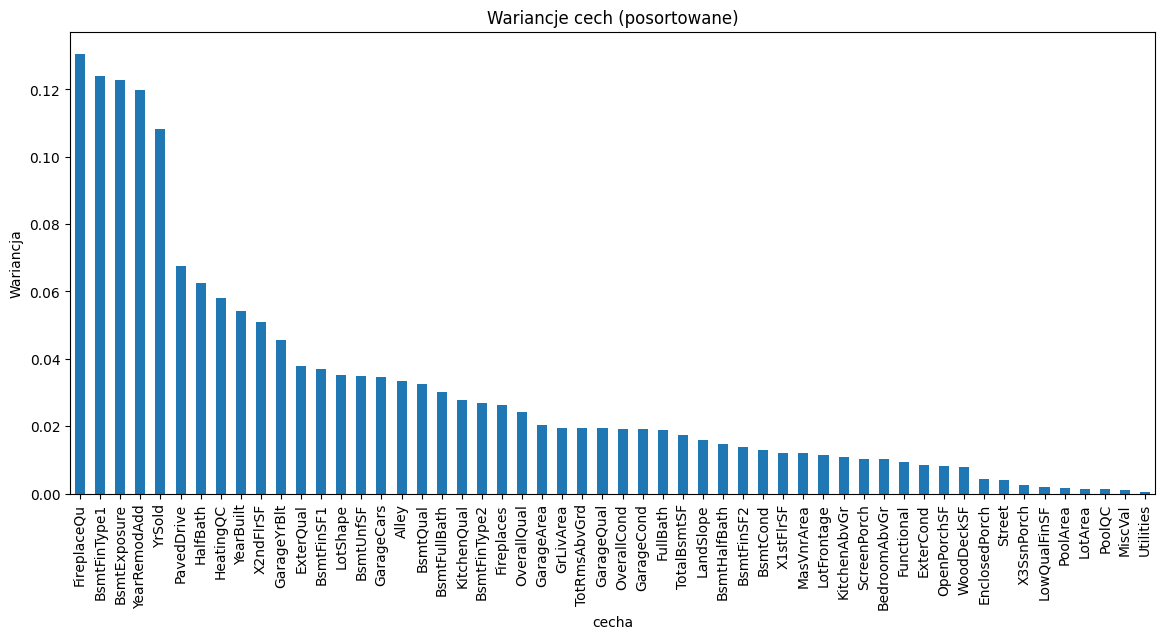

In [18]:
from matplotlib.pyplot import tight_layout, xlabel


variances = X_train_num.var()   
sorted_variances = variances.sort_values(ascending=False)
print(sorted_variances[-4:])
sorted_variances.plot.bar(figsize=(14, 6), title="Wariancje cech (posortowane)", ylabel='Wariancja', xlabel='cecha')

- myślę, że gdzieś tak w środku - coś pokroju 0.03
- tak np. te: LotArea, PoolQC, MiscVal, Utilities
- wydaję mi się, że posiadanie kominka to nie jest jakiś wielki gamechanger, więć niekoniecznie

Wariancja sprawdza tylko zmienność cech, a w szczególności nie uwzględnia żadnych interakcji między cechami. Sprawdźmy zatem liniowe korelacje pomiędzy cechami.

Jako że naszych cech jest bardzo dużo, to najpier warto narysować heatmapę korelacji, bez żadnych liczb, i wizualnie oszacować, czy mamy mocno skorelowane cechy.

<Axes: >

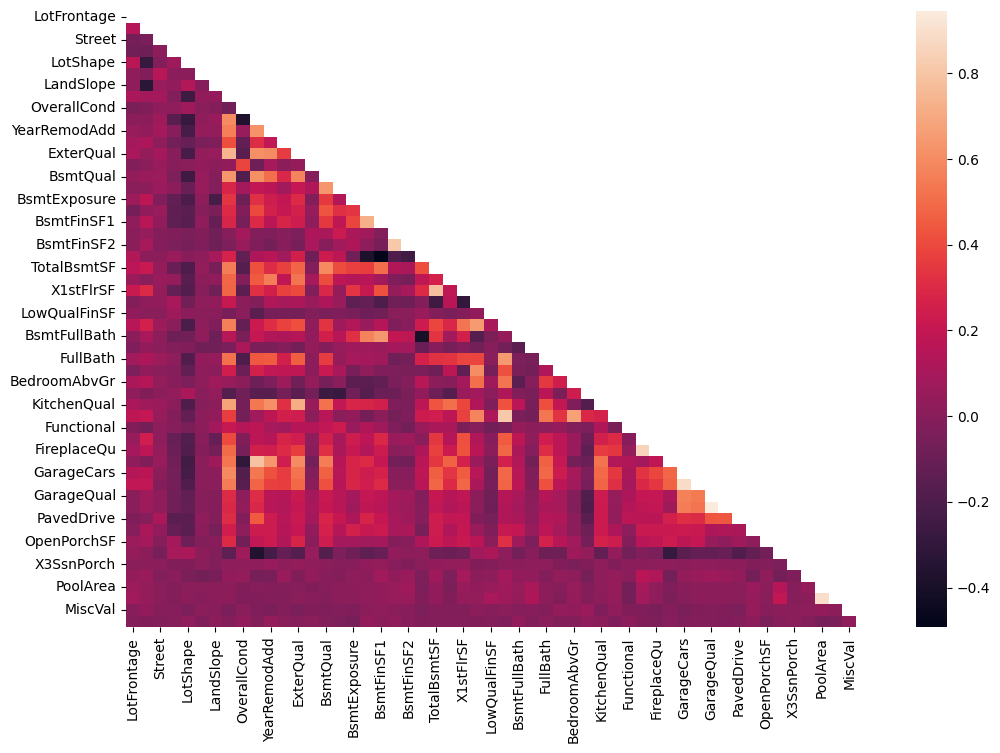

In [19]:
import seaborn as sns


corr_matrix = X_train_num.corr()
# remove upper triangle, to plot only lower triangle of correlations
corr_matrix = corr_matrix.where(~np.triu(np.ones(corr_matrix.shape)).astype(bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix)

Na oko nie ma tutaj wielu bardzo mocnych korelacji, rzędu 0.8 albo więcej. Mamy jednak dużo cech, więc warto popatrzeć też na same pary korelacji między kolumnami.

Tutaj liczy się ogólna siła korelacji, więc posortujemy malejąco po wartości bezwzględnej korelacji.

In [20]:
(corr_matrix.stack().sort_values(ascending=False, key=lambda x: abs(x)).head(10))

GarageCond    GarageQual      0.945034
PoolQC        PoolArea        0.899771
GarageArea    GarageCars      0.885777
FireplaceQu   Fireplaces      0.856795
TotRmsAbvGrd  GrLivArea       0.813288
BsmtFinSF2    BsmtFinType2    0.812546
GarageYrBlt   YearBuilt       0.791373
X1stFlrSF     TotalBsmtSF     0.780180
ExterQual     OverallQual     0.740265
BsmtFinSF1    BsmtFinType1    0.722830
dtype: float64

Jak widać, mamy jedną mocno skorelowaną parę - jakość i stan garażu. Ma to sens, w końcu to praktycznie zduplikowana informacja. Mamy też kilka par cech z dość mocnymi korelacjami powyżej 0.8. Ale biorąc pod uwagę, jak dużo cech mamy, to jest generalnie nieźle.

Ostatnią prostą miarą, którą zweryfikujemy, jest korelacja (konkretnie Pearson r correlation) między cechą a zmienną zależną. Scikit-learn implementuje ją jako funkcję, która przyjmuje macierz X, wektor y i zwraca wektor z wartością korelacji dla każdej cechy.

**Zadanie 2 (1 punkt)**

1. Zaimplementuj obliczanie korelacji między cechami z pomocą funkcji `r_regression` ze scikit-learn'a.
2. Skomentuj:
   - czy uzyskane korelacje dla cech są zgodne z oczekiwaniami i ogólnie mają sens?
   - mamy sporo cech o dość mocnej korelacji (0.5 lub więcej) - czy dobrze, czy źle, i dlaczego?
   - mamy cechę (LotShape) o wyraźniej negatywnej korelacji - czy takie cechy są użyteczne?

In [24]:
from sklearn.feature_selection import r_regression


pearson_corr = r_regression(X_train_num, y_train)
for col, corr in zip(X_train_num.columns, pearson_corr):
    print(f"{col} - {corr}")

LotFrontage - 0.15676519764574312
LotArea - 0.25566231556990954
Street - 0.09717691595375372
Alley - -0.08704182211610212
LotShape - -0.3274579547831605
Utilities - 0.03503960977846597
LandSlope - -0.04657480091604189
OverallQual - 0.83126136910925
OverallCond - -0.03849547359458259
YearBuilt - 0.6091839063414731
YearRemodAdd - 0.5841054378045946
MasVnrArea - 0.4445778978670456
ExterQual - 0.6802306007789367
ExterCond - 0.0862209975404611
BsmtQual - 0.6374210577218369
BsmtCond - 0.29280241541634344
BsmtExposure - 0.3843454435036721
BsmtFinType1 - 0.3813987674400545
BsmtFinSF1 - 0.42966196821730596
BsmtFinType2 - 0.04024928403506265
BsmtFinSF2 - 0.03316066747331244
BsmtUnfSF - 0.1885543789292532
TotalBsmtSF - 0.6538720076268166
HeatingQC - 0.5002148728766137
X1stFlrSF - 0.6213485505136254
X2ndFlrSF - 0.23993812670067124
LowQualFinSF - -0.04120577761304339
GrLivArea - 0.6987578514661782
BsmtFullBath - 0.2683371749015714
BsmtHalfBath - -0.02464323342086984
FullBath - 0.5699843795939322
Ha

- wydaję się jakby miało sens, bo np. ogólna jakość ma duży wynik, czyli wraz z wzrostem tej cechy rośnie cena domu
- hmm, chyba dobrze, bo jesteśmy w stanie zauważyć cechy, które najbardziej wpływają na cene domu
- ujemne cechy są użyteczne, bo oznaczają, że wraz ze wzrostem ich wartości spada cena domu

Przydałoby się w końcu przestać ignorować cechy kategoryczne i sprawdzić ważność faktycznie wszystkich cech. Można do tego użyć mutual information. Scikit-learn implementuje je jako funkcję, która przyjmuje X, y oraz informację o tym, które cechy są dyskretne. Mogą to być i cechy kategoryczne, i numeryczne, które mają wartości całkowite.

Mamy jednak problem - na wejściu mamy zmienne dyskretne, które zamieniliśmy na ciągłe przez min-max scaling. W przypadku mutual information nie należy tego robić, bo obsługuje wprost zmienne dyskretne.

**Zadanie 3 (3 punkty)**

1. Znajdź typy kolumn w danych:
   - kategoryczne: wszystkie typu "object"
   - numeryczne: wszystkie poza typem "object"
2. Stwórz pipeline do przetwarzania danych:
   - skorzystaj z klasy `ColumnTransformer`, przetwarzając w odpowiedni sposób zmienne (jak na laboratorium 1)
   - `OrdinalEncoder` do zmiennych kategorycznych, żeby zakodować je jako liczby całkowite
   - `SimpleImputer` do zmiennych numerycznych, aby imputować wartości brakujące medianą
   - użyj opcji `verbose_feature_names_out=False`, aby nazwy zmiennych nie były modyfikowane
3. Przetransformuj macierz `X_train`, tworząc `X_train_mi`.
4. Popraw z powrotem typy z pomocą metody `.convert_dtypes()` ([dokumentacja](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.convert_dtypes.html)) - zapewni to, że zmienne całkowitoliczbowe będą miały odpowiedni typ.
5. Oblicz wartości mutual information dla zmiennych. Pamiętaj o podaniu, które zmienne są dyskretne, oraz o przekazaniu `random_state=0`.
6. Przedstaw ważności cech według MI na wykresie, posortowane malejąco.
7. Dokonaj interpretacji cech:
   - Czy nienadzorowane miary, których użyliśmy wcześniej (wariancja i korelacja) zgadzają się ważnością cech z MI?
   - Czy MI i korelacja ze zmienną zależną zgadzają się ze sobą? Jeżeli nie, to której mierze można by zaufać bardziej?
   - Czy mamy tutaj cechy, które wyraźnie warto usunąć wedle miary MI? Czy ma to sens, patrząc na znaczenie tych cech?

Na obecnym etapie widać, że co najmniej kilka cech można by wyeliminować z naszego zbioru, a pewien zbiór wyraźnie dominuje. Używaliśmy jednak tylko metod typu filter. Wypróbujmy jeszcze metody typu embedded i wrapper.

Najpopularniejsze metody embedded to regresja liniowa i las losowy. Zgodnie z wynikami z laboratorium 1 użyjemy ridge regression (z regularyzacją L2), żeby zminimalizować przeuczenie. Co ważne, trzeba sprawdzić, czy te metody uzyskują dobre wyniki i czy nie przeuczają - metody embedded i wrapper wymagają dobrych modeli, aby dobrze oceniać ważność cech.

Pewną wadą tych metod w kontekście tego zbioru jest to, że nie działają dla zmiennych kategorycznych i musimy dokonać one-hot encodingu. Otrzymamy więcej zmiennych i trochę inne informacje o ważności cech - może się na przykład okazać, że tylko 1 czy 2 wartości dla zmiennej kategorycznej są mało ważne. To także przydatna informacja, bo można wtedy na przykład gromadzić mniej kategorii w przyszłości.

In [ ]:
from sklearn.preprocessing import OneHotEncoder


categorical_features = X_train.select_dtypes(include="object").columns
numerical_features = X_train.select_dtypes(exclude="object").columns

categorical_pipeline = OneHotEncoder(
    drop="first", sparse_output=False, handle_unknown="ignore"
)

numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

column_transformer = ColumnTransformer(
    [
        ("cat_pipeline", categorical_pipeline, categorical_features),
        ("num_pipeline", numerical_pipeline, numerical_features),
    ],
    verbose_feature_names_out=False,
)
column_transformer.fit(X_train)

X_train_processed = column_transformer.transform(X_train)
X_test_processed = column_transformer.transform(X_test)

In [ ]:
from sklearn.metrics import root_mean_squared_error


def assess_regression_model(model, X_train, X_test, y_train, y_test) -> None:
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_train_dollars = np.expm1(y_train)
    y_test_dollars = np.expm1(y_test)

    y_pred_train_dollars = np.expm1(y_pred_train)
    y_pred_test_dollars = np.expm1(y_pred_test)

    rmse_train_dollars = root_mean_squared_error(y_train_dollars, y_pred_train_dollars)
    rmse_test_dollars = root_mean_squared_error(y_test_dollars, y_pred_test_dollars)

    print(f"Train RMSE: {rmse_train_dollars:.2f}$")
    print(f"Test RMSE: {rmse_test_dollars:.2f}$")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge


reg_linear = LinearRegression(fit_intercept=False)
reg_linear.fit(X_train_processed, y_train)

reg_ridge = Ridge(random_state=0)
reg_ridge.fit(X_train_processed, y_train)

reg_rf = RandomForestRegressor(random_state=0)
reg_rf.fit(X_train_processed, y_train)

print("Linear regression")
assess_regression_model(
    reg_linear, X_train_processed, X_test_processed, y_train, y_test
)
print()
print("Ridge regression")
assess_regression_model(reg_ridge, X_train_processed, X_test_processed, y_train, y_test)
print()
print("Random Forest regression")
assess_regression_model(reg_rf, X_train_processed, X_test_processed, y_train, y_test)

Co ciekawe, w przypadku tego zbioru modele liniowe dają lepsze wyniki od złożonego lasu losowego! Może być to kwestia rozmiaru danych, lub po prostu potrzeby tuningu hiperparametrów. Trzeba jednak zauważyć, że każdy z modeli przeucza, nawet ridge regression, a selekcja cech redukuje overfitting dzięki usuwaniu szumu w danych.

W takim wypadku ewidentnie lepiej jest oprzeć się na ważności cech z modeli liniowych. Są to po prostu wagi z atrybutu `.coef_`. Jako że cech po one-hot encodingu jest bardzo dużo, to narysujemy wykres tylko dla najlepszych cech.

Cechy o wadze poniżej 0.01 można uznać za naprawdę słabe, bo mają minimalną wagę. Sprawdzimy, ile ich jest, oraz jakie są najmniej ważne według regresji liniowej cechy.

In [ ]:
importances_ridge = reg_ridge.coef_

# change to pd.Series for easier sorting and plotting
importances_ridge = pd.Series(importances_ridge, index=X_train_processed.columns)
importances_ridge = importances_ridge.sort_values(ascending=False, key=lambda x: abs(x))

# create horizontal bar plot for best features
importances_ridge.head(10).plot.barh(
    title="Highest feature importances - ridge regression", figsize=(12, 5)
)
plt.show()

# print number of very low weight features
num_low_weight_features = (importances_ridge.abs() <= 0.01).sum()
print("Number of features with weight <= 0.01:", num_low_weight_features)
print(
    f"This is {100 * num_low_weight_features / len(importances_ridge):.2f}% of all features"
)

print("Features with lowest weights:")
importances_ridge.tail(10)

Prawie 1/4 naszych cech ma praktycznie zerowy wpływ na predykcje regresji liniowej! Oczywiście w sumie ten wpływ może być całkiem spory, ale warto zauważyć, że jeżeli chcielibyśmy ostro redukować ilość zbieranych cech, np. ze względu na koszty przechowywania albo wymagania prawne, to jesteśmy w stanie to zrobić i prawdopodobnie nie obniży to bardzo wyników naszego modelu. Pamiętajmy też, że regresja liniowa skaluje się gorzej z liczbą cech, niż z liczbą próbek, więc tutaj różnica w szybkości może być faktycznie zauważalna.

Dokonaliśmy już wielu analiz i wiemy sporo o naszych cechach. Na cele analityczne tak naprawdę tyle by wystarczyło - możemy skupić się na niektórych, inne usunąć. Ta część to tak naprawdę business intelligence (BI), gdzie w tym wypadku skorzystaliśmy z uczenia maszynowego do głębszej analizy danych.

Teraz czas przejść do zastosowania selekcji cech w samym ML i budowaniu modeli predykcyjnych.

## Selekcja cech

Wykorzystamy teraz posiadane informacje, żeby dokonać selekcji cech.

Co do surowych, wejściowych cech wiemy, że:
- `Utilities` ma bardzo niską wariancję
- `GarageCond` i `GarageQual` są bardzo skorelowane
- jest szereg cech o praktycznie zerowej wartości wedle mutual information

To ostatnie będzie też zachodzić po one-hot encodingu - jeżeli cecha na wejściu jest bezużyteczna, to tym bardziej będzie bezużyteczna, kiedy potniemy ją na więcej cech. Możemy więc tego bezpiecznie dokonać.

**Zadanie 4 (1.5 punktu)**

Stwórz pipeline do przetwarzania zmiennych.

Kroki to po kolei:
1. `DropFeatures` z feature-engine, które usuwa kolumny `Utilities` i `GarageCond`
2. `ColumnTransformer`, który:
   - dla cech kategorycznych robi `OneHotEncoder`, pamiętaj o `drop="first", sparse_output=False, handle_unknown="ignore"`
   - dla cech numerycznych robi pipeline `SimpleImputer` oraz `MinMaxScaler`
   - użyj opcji `verbose_feature_names_out=False`, aby nazwy zmiennych nie były modyfikowane nazwą pipeline'
3. Selekcja cech z użyciem `SelectPercentile` ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html)), aby usunąć 10% najsłabszych cech według mutual information. Jako funkcję do obliczania wyniku wykorzystaj mutual information. Uwaga: musisz ręcznie stworzyć `score_func`, żeby podać `random_state=0`:
   ```
   scorer_mi = lambda X, y: mutual_info_regression(X, y, random_state=0)
   ```

Przetransformowane `X_train` i `X_test` zapisz w zmiennych `X_train_preproc` i `X_test_preproc`.

**Uwaga:** przy tworzeniu listy zmiennych numerycznych pamiętaj, żeby usunąć z niej nazwy usuwanych kolumn, tj. `Utilities` i `GarageCond`.

Mamy teraz pełen zestaw cech, gotowy do treningu regresji liniowej.

In [ ]:
reg_ridge = Ridge(random_state=0)
reg_ridge.fit(X_train_preproc, y_train)

assess_regression_model(reg_ridge, X_train_preproc, X_test_preproc, y_train, y_test)

Wynik testowy jest bardzo podobny, natomiast błąd treningowy jest większy. Czy to gorzej? Otóż niekoniecznie - w końcu teraz przeuczamy mniej. Taki model może być mniej podatny na szum i błędne pomiary, dając bardziej pewne (robust) wyniki w przyszłości.

Nie wykorzystaliśmy jednak jeszcze ważnej metody selekcji cech - Recursive Feature Elimination (RFE).

**Zadanie 5 (2 punkty)**

1. Zastosuj RFECV ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)) do selekcji cech:
   - użyj ridge regression jako estymatora bazowego
   - wybierz co najmniej 80% oryginalnych cech
   - zastosuj 10-krotną walidację skrośną
   - pamiętaj o `random_state=0`
   - może się przydać `n_jobs=-1`
2. Przetransformuj `X_train_preproc` i `X_test_preproc`, tworząc `X_train_reduced` i `X_test_reduced`. Sprawdź, ile cech usunięto.
3. Wytrenuj ridge regression na zredukowanych cechach.
4. Sprawdź wyniki na zbiorze treningowym i testowym (skorzystaj z `assess_regression_model`).

Sumarycznie wyeliminowaliśmy sporo cech, a nasz model uzyskuje wyniki bardzo podobne do wyjściowych.

## Redukcja wymiarowości

Na koniec skupimy się na redukcji wymiarowości w celu wizualizacji zbiorów danych z wykorzystaniem Principal Components Analysis (PCA). Co prawda w naszym zbiorze mamy dużo cech rzadkich, co nie jest sytuacją idealną dla PCA, bo centruje ona cechy, ale mamy też sporo cech gęstych. Zrzutujemy nasz zbiór na 2D, kolorując go według wartości zmiennej zależnej.

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2, random_state=0)
pca.fit(X_train_preproc)


X_train_embed = pca.transform(X_train_preproc)
X_train_embed = X_train_embed.values

plt.scatter(X_train_embed[:, 0], X_train_embed[:, 1], c=y_train)

Jak widać, nawet po ekstremalnej liniowej redukcji do 2D nasze dane zachowują w miarę strukturę, z większymi (jaśniejszymi) wartościami po prawej, i mniejszymi (ciemniejszymi), w prawym dolnym rogu. Jeżeli liniowa redukcja dobrze działa, to znaczy, że wejściowe cechy były na tyle dobre, że nawet ich liniowa kombinacja zachowuje dużo informacji.

Takie wykresy są często nieco bardziej informatywne w przypadku klasyfikacji, gdzie dodatkowo możemy obserwować klastry formowane przez klasy, ale nawet przy tej regresji widać, że efekty są całkiem sensowne. Takie ładne ułożenie danych po prostym PCA wyjaśnia też, czemu proste metody liniowe na tym zbiorze działają dość dobrze.

**Zadanie 6 (2 punkty)**

1. Załaduj zbiór danych Give Me Some Credit z laboratorium 4.
2. Wyodrębnij `SeriousDlqin2yrs` jako zmienną `y`.
3. Dokonaj przetwarzania cech:
   - imputacja medianą (`SimpleImputer` z odpowiednimi opcjami)
   - usuwanie outlierów (`OutlierTrimmer`)
   - przycinanie wartości (`Winsorizer`)
4. Stwórz dodatkowną zmienną `X_scaled` po standaryzacji (`StandardScaler`) - PCA działa lepiej po przeskalowaniu cech.
5. Zastosuj PCA, żeby zredukować `X_scaled` do 2 wymiarów.
6. Narysuj scatter plot: klasa 0 (spłaca kredyt) niebieska, klasa 1 (nie spłaca kredytu) czerwona. Dodaj odpowiedni tytuł oraz legendę.
7. Wybierz wiersze z klasy negatywnej, które znajdują się dość daleko od typowych, co zobaczysz na wykresie. Chcemy wybrać wiersze z DataFrame'a przed skalowaniem, żeby mieć interpretowalne wartości cech.
8. Porównaj wartości dla:
   - całości zbioru (po czyszczeniu)
   - jego klasy negatywnej
   - samych nietypowych punktów

Może się tu przydać np. `.describe()` oraz `np.argwhere()`. Która średnia może odpowiadać za tą nietypowość? Podpowiedź: porównaj średnie wartości.

// skomentuj tutaj

## Zadanie dodatkowe (3 punkty)

Na zbiorze danych [Polish companies bankruptcy](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data) z laboratorium 5 (podzbiór z 3 lat) dokonaj analizy ważności cech, ich selekcji, oraz wizualizacji z pomocą redukcji wymiarowości. Zbiór zawiera same zmienne numeryczne.

1. Dokonaj analizy korelacji cech. Usuń najmocniej skorelowane cechy, próg dobierz wedle własnego uznania - może się przydać biblioteka [feature-engine](https://feature-engine.trainindata.com/en/1.3.x/user_guide/selection/SmartCorrelatedSelection.html).
2. Dokonaj analizy ważności cech z pomocą algorytmu Boruty, realizującego all-relevant feature selection. Przykładowa implementacja jest w bibliotece [ARFS](https://arfs.readthedocs.io/en/latest/Methods%20overview.html). Wykorzystaj klasyczny algorytm Boruty oraz metodę Leshy (z pewnymi modyfikacjami) - [przykład w ARFS](https://arfs.readthedocs.io/en/latest/notebooks/arfs_classification.html). Czy wybrano wszystkie cechy, czy tylko ich podzbiór?
3. Porównaj wyniki z mutual information oraz RFECV używającego LightGBM (z domyślnymi hiperparametrami). Czy wyniki różnią się od algorytmu Boruty?
4. Wytrenuj LightGBM (pamiętaj o wagach klas) na cechach po selekcji:
   - algorytmem Boruty
   - algorytmem Leshy
   - mutual information
   - RFECV
5. Dokonaj wizualizacji dla każdego zestawu cech:
   - używając liniowej redukcji wymiaru z PCA
   - używając nieliniowej redukcji wymiaru z [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - dla każdego wykresu pokoloruj go prawdziwymi klasami
6. Porównaj AUROC na zbiorze testowym oraz wybraną liczbę cech dla każdej z metod. Która metoda twoim zdaniem jest tutaj najlepsza? Która metoda (zestaw cech) daje najlepiej wyglądającą redukcję wymiaru?